# Setup

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import pandas as pd

from network import Net, NetDiscovery
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)
np.random.seed(10)

# Training Data and Nondimensionalization

In [6]:
# Grab training data
train_t, train_x = grab_training_data()

# Plot training data
plt.plot(train_t, train_x, 'o')
plt.legend(['Normal training data 3mm'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.show()

KeyError: 'TIME_1MM'

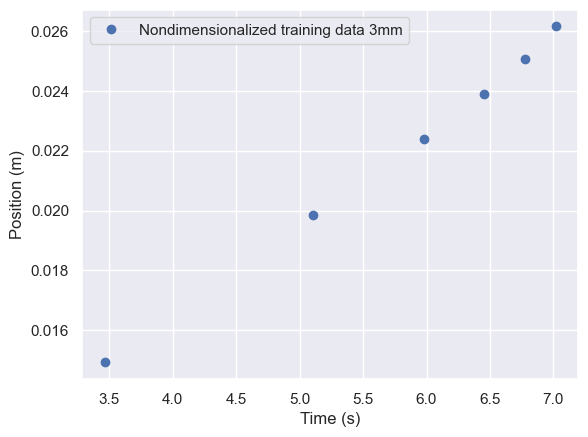

In [12]:
plt.plot(nondim_train_t, nondim_train_x, 'o')
plt.legend(['Nondimensionalized training data 3mm'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.show()

# Trying Different Loss Weights for Physics Loss + Data Loss

In [13]:
# different_lambdas = torch.linspace(0, 500, 25)
# losses_each_lambda = torch.empty(len(different_lambdas))

# for i in range(0, len(different_lambdas)):
#     net = Net(1,1, loss2=physics_loss, epochs=5000, loss2_weight=different_lambdas[i], lr=0.5).to(DEVICE)
#     losses_each_lambda[i] = net.fit(train_t, train_x)[-1]

# plt.plot(different_lambdas, losses_each_lambda)
# plt.legend(['Loss vs. Lambda'])
# plt.ylabel('Loss')
# plt.xlabel('Lambda')

# Learn the Model

Epoch 0/5000, data loss: 695600.0, physics loss: 18253.69921875
Epoch 500/5000, data loss: 7.991980075836182, physics loss: 0.14079929888248444
Epoch 1000/5000, data loss: 1.1637074947357178, physics loss: 0.14282628893852234
Epoch 1500/5000, data loss: 0.7197427749633789, physics loss: 0.14300240576267242
Epoch 2000/5000, data loss: 0.5756581425666809, physics loss: 0.14313755929470062
Epoch 2500/5000, data loss: 0.5156447887420654, physics loss: 0.14323310554027557
Epoch 3000/5000, data loss: 0.46934273838996887, physics loss: 0.1433064490556717
Epoch 3500/5000, data loss: 0.42031219601631165, physics loss: 0.1433895230293274
Epoch 4000/5000, data loss: 0.36620625853538513, physics loss: 0.14347414672374725
Epoch 4500/5000, data loss: 0.30951523780822754, physics loss: 0.1435910314321518


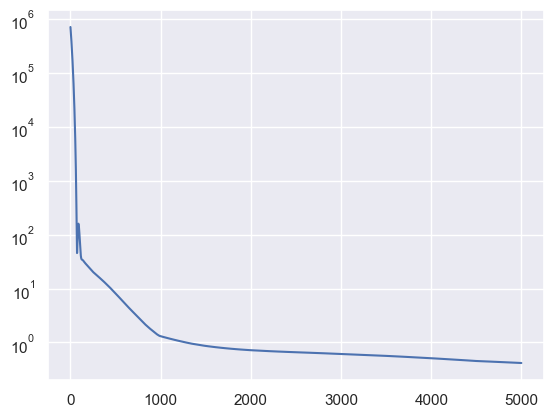

In [14]:
net = Net(1, 1, loss2=physics_loss, epochs=5000, loss1_weight=100000000, loss2_weight=0.00001, lr=1e-5).to(DEVICE)
losses = net.fit(nondim_train_t, nondim_train_x)
plt.plot(losses)
plt.yscale('log')

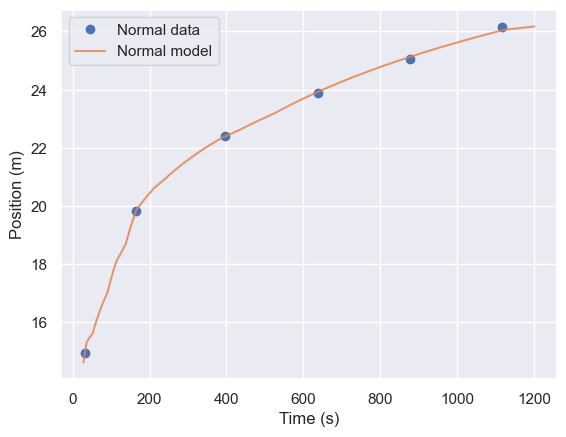

In [15]:
times = np.linspace(3.35, np.log(1200), 1200)
preds = net.predict(times)

plt.plot(train_t, train_x, 'o')
plt.plot(np.exp(times), x_0*preds, alpha=0.8)
plt.legend(['Normal data', 'Normal model'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.show()

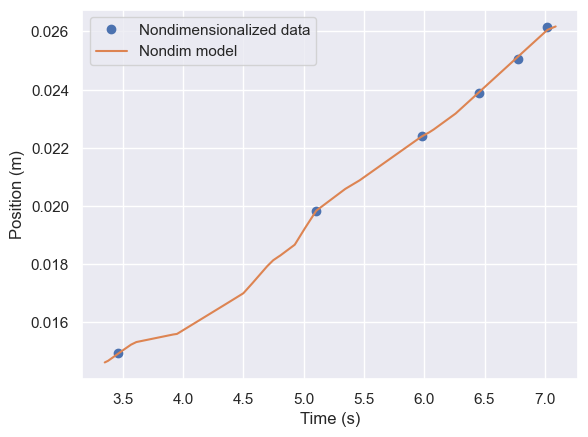

In [16]:
plt.plot(nondim_train_t, nondim_train_x, 'o')
plt.plot(times, preds)
plt.legend(['Nondimensionalized data', 'Nondim model'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.show()